In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.patches import Rectangle,Polygon
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42

import os,glob,re
import numpy as np
# from Bio import SeqIO
# from collections import Counter

import baltic as bt

locs={}
loc_size={'town': 1, 'county': 2, 'country': 3}
coordinates={'Liège': (50.63373,5.56749,'town'), 
             'England': (51.509865,-0.118092,'country'), 
             'Rhineland-Palatinate': (49.992863,8.247253,'county'), 
             'Geneva': (46.204391,6.143158,'county'), 
             'Sint-Joost-ten-Node': (50.85,4.383333,'town'), 
             'Vilniaus apskritis': (54.68916,25.2798,'county'), 
             'Lower Saxony': (52.373920,9.735603,'county'), 
             'Bavaria': (48.777500,11.431111,'county'), 
             'La Roche-sur-Yon': (46.670502,-1.426000,'town'), 
             'Issoire': (45.55,3.25,'town'), 
             'Maryland': (-76.641273,39.045753,'country'), 
             'Pontoise': (49.051601,2.101700,'town'), 
             'Taurages': (55.25222, 22.28972,'county'), 
             'Utenos': (55.5,25.6,'county'), 
             'Utenos apskritis': (55.5,25.6,'county'), 
             'Vilassar De Mar': (41.50408,2.39226,'town'), 
             'Utena': (55.5,25.6,'county'), 
             'Germany': (52.531677,13.381777,'country'), 
             'Vilnius': (54.68916,25.2798,'county'), 
             'Asse': (50.91011,4.19836,'town'), 
             'West Virginia': (-79.940918,32.784618,'country'), 
             'Cluses': (46.060390,6.580582,'town'), 
             'CAR': (6.6194,20.9367,'country'), 
             'Hauts-de-France': (50.629250,3.057256,'county'), 
             'Equatorial Guinea': (1.6195,10.3178,'country'), 
             'Olomouc Region': (49.593778,17.250879,'county'), 
             'Le Havre': (49.490002,0.100000,'town'), 
             'Lochristi': (51.097461,3.837824,'town'), 
             'Buggenhout': (51.0159,4.20173,'town')}


travel={}
for line in open('/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/data/travel_qc_info.csv','r'):
    l=line.strip('\n').split('\t')
#     print(l[3])
    if l[0]!='Virus name':
        name=l[0]
        if 'Czech' in name: name=name.replace('_','')
        if 'Equatorial' in name: name=name.replace('_','')
        
        locs[name]=[c.strip(' ') for c in l[3].split('/')][-1]
        if l[4]!='':
            travel[name]=l[4]

locs['hCoV-19/Belgium/Aalst-OLVZ-8042639/2021']='Asse'
locs['hCoV-19/Belgium/UGent-4359/2021']='Lochristi'
locs['hCoV-19/Belgium/UGent-4369/2021']='Buggenhout'

locs['hCoV-19/CAR/245/2021']='CAR'
locs['hCoV-19/CAR/242/2021']='CAR'
locs['hCoV-19/CAR/226/2021']='CAR'
locs['hCoV-19/CAR/229/2021']='CAR'
locs['hCoV-19/CAR/237/2021']='CAR'
locs['hCoV-19/CAR/234/2021']='CAR'
locs['hCoV-19/CAR/235/2021']='CAR'

colours={}
for line in open('/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/colours.csv','r'):
    loc,colour=line.strip('\n').split('\t')
    colours[loc]=colour
    
colours['UnitedKingdom']=colours['England']
colours['EquatorialGuinea']=colours['Equatorial Guinea']
colours['CzechRepublic']=colours['Czech Republic']
# ll=ll.reduceTree([k for k in ll.getExternal() if 'ancestor_taxon' not in k.name])
# ll.sortBranches()

{'Asia': 0.00018768768768768769, 'Europe': 0.24943693693693694, 'Africa': 0.7503753753753754, 'other': 0}
{'Cameroon': 0.9911080711354309, 'USA': 0.0007979936160510716, 'Portugal': 0.00011399908800729594, 'Switzerland': 0.00011399908800729594, 'Mali': 0.00045599635202918376, 'Ireland': 0.00045599635202918376, 'UnitedKingdom': 0.0013679890560875513, 'France': 0.00022799817601459188, 'EquatorialGuinea': 0.00011399908800729594, 'other': 0.005243958048335613}


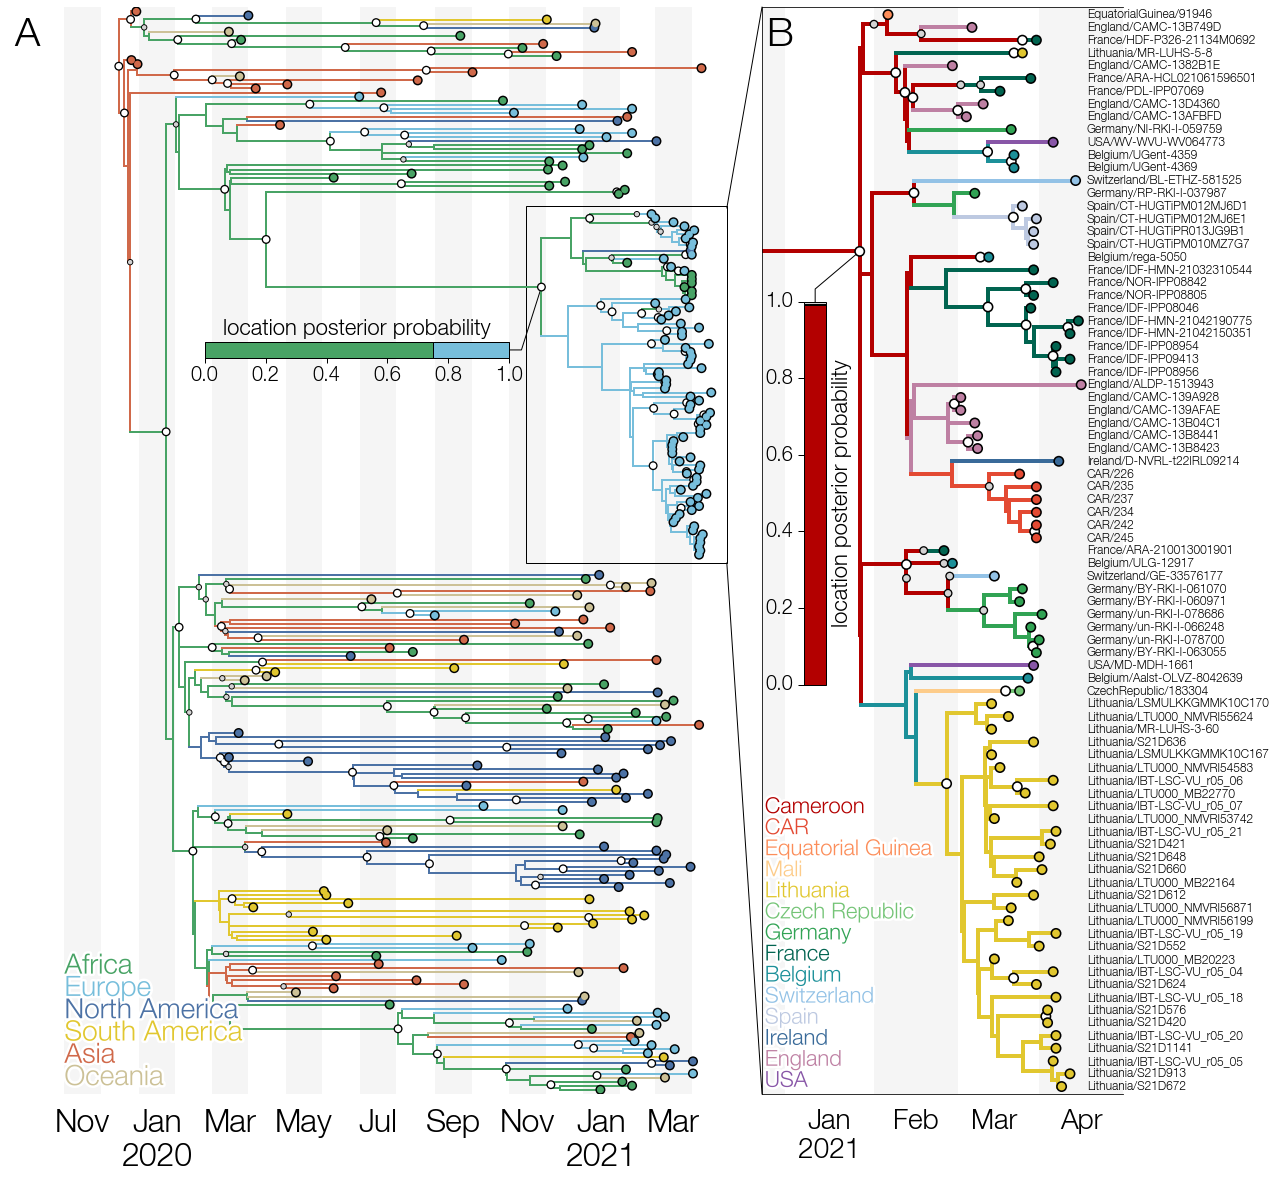

In [2]:
fig = plt.subplots(figsize=(20,20),facecolor='w')

gs = GridSpec(1,2,hspace=0.01,wspace=0.06,width_ratios=[2,1])
ax=plt.subplot(gs[0])

x_attr=lambda k: k.absoluteTime

tree_path='/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/data/trees/continent_combined.mcc.tre'

ll=bt.loadNexus(tree_path)
ll=ll.reduceTree([k for k in ll.getExternal() if 'ancestor_taxon' not in k.name])
ll.sortBranches()


ca=ll.commonAncestor(ll.getExternal(lambda w: w.name.split('|')[0] in locs))
# print(bt.calendarDate(ca.absoluteTime))
# s=100

pad_nodes={ca:4}
ll.drawTree(pad_nodes=pad_nodes)


ll.plotTree(ax,x_attr=x_attr,colour=lambda k: colours[k.traits['loc']],width=2)
ll.plotPoints(ax,x_attr=x_attr,size=50,colour=lambda k: colours[k.traits['loc']],zorder=1000)

done=[]
for k in ll.getExternal():
    strain=k.name.split('|')[1] if len(k.name.split('|'))>1 else ''
    if strain in locs:
#         print()
        lat,lon,size=coordinates[locs[strain]]
        
        skip=0.0001
        s=60
        
        country=strain.split('/')[1]
        country=country.replace('_',' ')
        fc=colours[country]
        ec='k'
        scale=1.8
        if strain in travel:
            ec='red'
            s=60
            scale=3
#             if 'Lithuania' in strain:
            ec=colours[travel[strain]]
    
        ax.scatter(k.absoluteTime,k.y,s=s,facecolor=fc,edgecolor='none',zorder=10000)
        ax.scatter(k.absoluteTime,k.y,s=s*scale,facecolor=ec,edgecolor='none',zorder=9999)

ax.plot()



start='2019-11-01'
end='2021-05-01'
cur=start
timeline=[]
while bt.decimalDate(cur)<bt.decimalDate(end):
    timeline.append(cur)
    yr,mon,day=cur.split('-')
    
    if mon=='12':
        mon='01'
        yr=int(yr)
        yr+=1
        yr=str(yr)
    else:
        mon=int(mon)
        mon+=1
        mon='%02d'%(mon)
    
    cur='-'.join([yr,mon,day])
    
# print(timeline)

ax.set_xticks([x+15/365 for x in map(bt.decimalDate,timeline)])

xlabels=[]
for d,date in enumerate(timeline):
#     if (d+1)%3==0:
    if d%2==0:
        if '-01-01' not in date:
            xlabels.append(bt.convertDate(date,'%Y-%m-%d','%b'))
        else:
            xlabels.append(bt.convertDate(date,'%Y-%m-%d','%b\n%Y'))
    else:
        xlabels.append('')
        
# ax.set_xticklabels([bt.convertDate(d,'%Y-%m-%d','%b') if '-01-01' not in d else bt.convertDate(d,'%Y-%m-%d','%b\n%Y') for d in timeline])
ax.set_xticklabels(xlabels)

[ax.axvspan(d,d+30/365,facecolor='k',edgecolor='none',alpha=0.04,zorder=0) for i,d in enumerate(map(bt.decimalDate,timeline)) if i%2==0]


ax.set_yticks([])
ax.set_yticklabels([])

ax.tick_params(size=0,labelsize=32,pad=15)

[ax.spines[loc].set_visible(False) for loc in ax.spines]
ax.set_xlim(bt.decimalDate('2019-09-15'),bt.decimalDate('2021-05-01'))
ax.set_ylim(-0.6,ll.ySpan+0.6)
###########
ca=ll.commonAncestor(ll.getExternal(lambda w: w.name.split('|')[0] in locs))
# print(bt.calendarDate(ca.absoluteTime))
# s=100


pad_x=0.07
pad_y=3
ax.add_patch(Rectangle((ca.absoluteTime-pad_x/2,min(ca.yRange)-0.5-pad_y/2),ll.mostRecent-ca.absoluteTime+pad_x,len(ca.leaves)+pad_y,ls='-',facecolor='none',edgecolor='k',zorder=0,alpha=1))

x=bt.decimalDate('2020-11-01')
y=181
h=4
L=250/365
cumulative_p=0

ax.text(x-L/2,y+h+0.8,'location posterior probability',size=22,ha='center',va='bottom')

loc_probs={l: p for l,p in zip(ca.traits['loc.set'],ca.traits['loc.set.prob'])}

other_prob=[l for l in loc_probs if l not in colours] ## locations for which no colour available
loc_probs['other']=sum([loc_probs[l] for l in other_prob])


for loc in other_prob:
    del loc_probs[loc] ## remove countries
print(loc_probs)
ax.plot([x,x+10/365,ca.absoluteTime],[y+h/2,y+h/2,ca.y],color='k',ls='-',lw=1,zorder=0)

for loc in loc_probs:
    fc=colours[loc] if loc in colours else 'lightgrey'
    ec='k'
    p=loc_probs[loc]
    ax.add_patch(Rectangle((x-cumulative_p-p*L,y),p*L,h,lw=1,facecolor=fc,edgecolor=ec,zorder=1))
    
    cumulative_p+=p*L

#############
ticks=np.linspace(0,1,6)
tick_coordinates=[(x-L)+i*L for i in ticks]

ax.eventplot(tick_coordinates,lineoffsets=y,linelengths=-2.5,color='k',lw=1,zorder=0)

for i,j in zip(tick_coordinates,ticks):
    ax.text(i,y-1.8,'%.1f'%(j),va='top',ha='center',size=20)
#############
#############

############
h=5
w=25/365
# for c,country in enumerate(['USA', 'England', 'Spain', 'Switzerland', 'Belgium', 'France', 'Germany', 'Czech Republic', 'Lithuania', 'Mali', 'Equatorial Guinea', 'CAR', 'Cameroon']):
for c,country in enumerate(['Africa','Europe','North America','South America','Asia','Oceania'][::-1]):
    x=bt.decimalDate('2019-11-01')
    y=1+c*h*1.1
    fc=colours[country.replace(' ','')]
#     fc=desaturate(fc,0.6)
    effects=[path_effects.Stroke(linewidth=5, foreground='white'),
             path_effects.Stroke(linewidth=0, foreground=fc)] ## black text, white outline
    
#     ax.add_patch(Rectangle((x,y),w,h,facecolor=fc,edgecolor='none',clip_on=False))
    ax.text(x,y+h/2,country,size=28,color=fc,va='center',path_effects=effects)
###########

for k in ll.getInternal():
    if k.is_node():
        if k.traits['posterior']>=0.95:
            s=40
            ax.scatter(k.absoluteTime,k.y,s=s,facecolor='w',edgecolor='none',zorder=100)
            ax.scatter(k.absoluteTime,k.y,s=s*2,facecolor='k',edgecolor='none',zorder=99)
        elif k.traits['posterior']>=0.5:
            s=20
#             ax.scatter(k.absoluteTime,k.y,s=s,facecolor='none',edgecolor='lightgrey',zorder=100)
            ax.scatter(k.absoluteTime,k.y,s=s,facecolor='lightgrey',edgecolor='none',zorder=100)
            ax.scatter(k.absoluteTime,k.y,s=s*2,facecolor='k',edgecolor='none',zorder=99)

ax.text(0.01,0.99,'A',size=40,ha='left',va='top',transform=ax.transAxes)

################
ax2=plt.subplot(gs[1])

con = ConnectionPatch(xyA=(ll.mostRecent+pad_x/2,min(ca.yRange)-0.5-pad_y/2), 
                      coordsA=ax.transData, 
                      axesA=ax2,
                      xyB=(0,0), 
                      coordsB=ax2.transAxes,
                      axesB=ax2, 
                      color='k', ls='-',lw=1,zorder=3,alpha=1)
ax2.add_patch(con)

con = ConnectionPatch(xyA=(ll.mostRecent+pad_x/2,max(ca.yRange)+pad_y/2), 
                      coordsA=ax.transData, 
                      axesA=ax2,
                      xyB=(0,1), 
                      coordsB=ax2.transAxes,
                      axesB=ax2, 
                      color='k', ls='-',lw=1,zorder=3,alpha=1)
            
ax2.add_patch(con)


# ll2=ll.subtree(ca)
ll2=bt.loadNexus('/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/data/trees/1ghost.combined.mcc.tre')
ll2=ll2.reduceTree([k for k in ll2.getExternal() if 'ancestor_taxon' not in k.name])

ca=ll2.commonAncestor(ll2.getExternal(lambda w: w.name.split('|')[0] in locs))
ll2=ll2.subtree(ca)
    
ll2.sortBranches()

ll2.plotTree(ax2,x_attr=x_attr,colour=lambda k: colours[k.traits['loc']],width=4)
# ll2.plotTree(ax2)

ll2.plotPoints(ax2,x_attr=x_attr,size=60,colour=lambda k: colours[k.traits['loc']],zorder=1000)


text=lambda k: '/'.join(k.name.split('|')[0].split('/')[1:-1])

ll2.addText(ax2,x_attr=lambda k: max(ll2.getParameter('absoluteTime'))+2/365,size=12,text=text,ha='left',va='center')

#############
for k in ll2.getInternal():
    if k.is_node():
        if k.traits['posterior']>=0.95:
            s=60
            ax2.scatter(k.absoluteTime,k.y,s=s,facecolor='w',edgecolor='none',zorder=100)
            ax2.scatter(k.absoluteTime,k.y,s=s*2,facecolor='k',edgecolor='none',zorder=99)
        elif k.traits['posterior']>=0.5:
            s=40
#             ax.scatter(k.absoluteTime,k.y,s=s,facecolor='none',edgecolor='lightgrey',zorder=100)
            ax2.scatter(k.absoluteTime,k.y,s=s,facecolor='lightgrey',edgecolor='none',zorder=100)
            ax2.scatter(k.absoluteTime,k.y,s=s*2,facecolor='k',edgecolor='none',zorder=99)
#############



loc_probs={l: p for l,p in zip(ca.traits['loc.set'],ca.traits['loc.set.prob'])}

other_prob=[l for l in loc_probs if l not in colours] ## locations for which no colour available
loc_probs['other']=sum([loc_probs[l] for l in other_prob])


for loc in other_prob:
    del loc_probs[loc] ## remove countries
print(loc_probs)

x=bt.decimalDate('2021-01-07')
y=32
w=8/365
H=30
cumulative_p=0

ax2.plot([x+w/2,x+w/2,ca.absoluteTime],[y+H,y+H+1,ca.y],color='k',ls='-',lw=1,zorder=0)
ax2.text(x+w+2/365,y+H/2,'location posterior probability',size=22,ha='left',va='center',rotation=90)


for loc in loc_probs:
    fc=colours[loc] if loc in colours else 'lightgrey'
    ec='k'
    p=loc_probs[loc]
    ax2.add_patch(Rectangle((x,y+cumulative_p),w,p*H,lw=1,facecolor=fc,edgecolor=ec,zorder=1))
#     print(loc,p,cumulative_p,cumulative_p*H)
    cumulative_p+=p*H

#############
ticks=np.linspace(0,1,6)
tick_coordinates=[y+i*H for i in ticks]

ax2.eventplot(tick_coordinates,orientation='vertical',lineoffsets=x,linelengths=-4/365,color='k',lw=1,zorder=0)

for i,j in zip(tick_coordinates,ticks):
    ax2.text(x-4/365,i,'%.1f'%(j),va='center',ha='right',size=20)
#############

h=1.5
w=25/365
for c,country in enumerate(['USA', 'England', 'Ireland', 'Spain', 'Switzerland', 'Belgium', 'France', 'Germany', 'Czech Republic', 'Lithuania', 'Mali', 'Equatorial Guinea', 'CAR', 'Cameroon']):
# for c,country in enumerate(['Africa','Europe','North America','South America','Asia','Oceania'][::-1]):

    x=bt.decimalDate('2020-12-24')
    y=0.2+c*h*1.1
    fc=colours[country]
#     fc=desaturate(fc,0.6)
    effects=[path_effects.Stroke(linewidth=5, foreground='white'),
             path_effects.Stroke(linewidth=0, foreground=fc)] ## black text, white outline
    
#     ax.add_patch(Rectangle((x,y),w,h,facecolor=fc,edgecolor='none',clip_on=False))
    ax2.text(x,y+h/2,country,size=22,color=fc,va='center',path_effects=effects)
#############


ax2.set_yticks([])
ax2.set_yticklabels([])

ax2.tick_params(size=0,labelsize=28,pad=15)

ax2.set_xticks([x+15/365 for x in map(bt.decimalDate,timeline)])
ax2.set_xticklabels([bt.convertDate(date,'%Y-%m-%d','%b') if '-01-01' not in date else bt.convertDate(date,'%Y-%m-%d','%b\n%Y') for date in timeline])

[ax2.axvspan(d,d+30/365,facecolor='k',edgecolor='none',alpha=0.04,zorder=0) for i,d in enumerate(map(bt.decimalDate,timeline)) if (i+1)%2==0]


[ax2.spines[loc].set_linestyle('-') for loc in ax2.spines]
ax2.spines['right'].set_visible(False)

ax2.set_xlim(bt.decimalDate('2020-12-23'),bt.decimalDate('2021-05-01'))
ax2.set_ylim(-0.1,ll2.ySpan+0.1)


ax2.text(0.01,0.99,'B',size=40,ha='left',va='top',transform=ax2.transAxes)

# plt.savefig('/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/figures/Fig4_MCC.png',dpi=100,bbox_inches='tight')

plt.savefig('/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/figures/Fig4_MCC.pdf',dpi=100,bbox_inches='tight')
plt.show()